In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill()) #kendinden sonraki değere göre
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

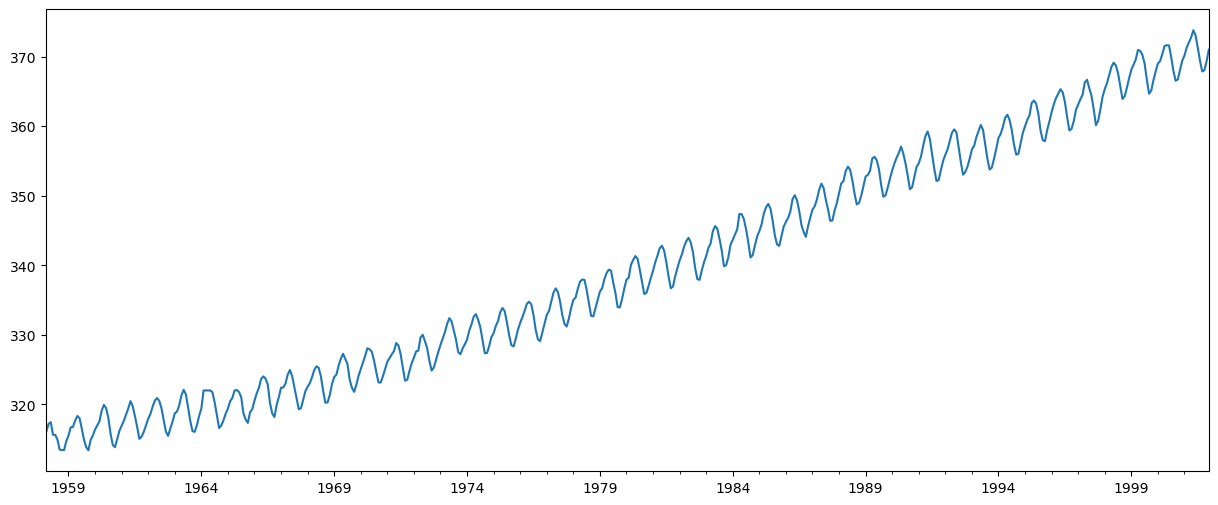

In [3]:
y.plot(figsize = (15, 6))
plt.show()

In [4]:
train = y[:'1997-12-01']
test = y['1998-01-01':]

### ARIMA(p, d, q): Autoregressive Integrated Moving Average

In [5]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

In [6]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Wed, 22 Jan 2025   AIC                           1157.537
Time:                        16:01:46   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
y_pred = arima_model.forecast(48)
y_pred = pd.Series(y_pred, index=test.index)

In [8]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title = f"{title}, MAE: {round(mae, 2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

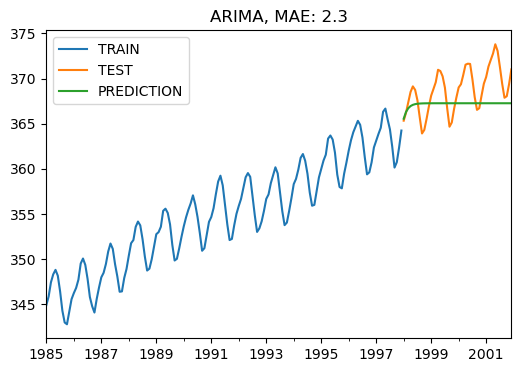

In [9]:
plot_co2(train, test, y_pred, "ARIMA")

##### Hyperparameter Optimization

AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme

In [10]:
p=d=q=range(0, 4)
pdq = list(itertools.product(p, d, q))

In [11]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' %(best_params, best_aic))
        
    return best_params           

In [12]:
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 0, 2) AIC=2771.31
ARIMA(0, 0, 3) AIC=2328.74
ARIMA(0, 1, 0) AIC=1523.91
ARIMA(0, 1, 1) AIC=1254.79
ARIMA(0, 1, 2) AIC=1137.97
ARIMA(0, 1, 3) AIC=1094.51
ARIMA(0, 2, 0) AIC=1279.81
ARIMA(0, 2, 1) AIC=1257.89
ARIMA(0, 2, 2) AIC=1247.74
ARIMA(0, 2, 3) AIC=1141.50
ARIMA(0, 3, 0) AIC=1482.91
ARIMA(0, 3, 1) AIC=1286.29
ARIMA(0, 3, 2) AIC=1264.05
ARIMA(0, 3, 3) AIC=1253.48
ARIMA(1, 0, 0) AIC=1536.61
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.98
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1207.78
ARIMA(1, 1, 1) AIC=1157.54
ARIMA(1, 1, 2) AIC=1113.98
ARIMA(1, 1, 3) AIC=1095.90
ARIMA(1, 2, 0) AIC=1256.05
ARIMA(1, 2, 1) AIC=1257.80
ARIMA(1, 2, 2) AIC=1161.11
ARIMA(1, 2, 3) AIC=1117.55
ARIMA(1, 3, 0) AIC=1418.84
ARIMA(1, 3, 1) AIC=1262.07
ARIMA(1, 3, 2) AIC=1263.84
ARIMA(1, 3, 3) AIC=1253.50
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.38
ARIMA(2, 0, 2) AIC=1124.96
ARIMA(2, 0, 3) AIC=1106.92
ARIMA(2, 1, 0) AIC=1103.53
A

In [13]:
best_params_aic

(2, 1, 3)

In [14]:
arima_model_final = ARIMA(train, order=(2, 1, 3)).fit()
y_pred = arima_model_final.forecast(48)
y_pred = pd.Series(y_pred, index=test.index)

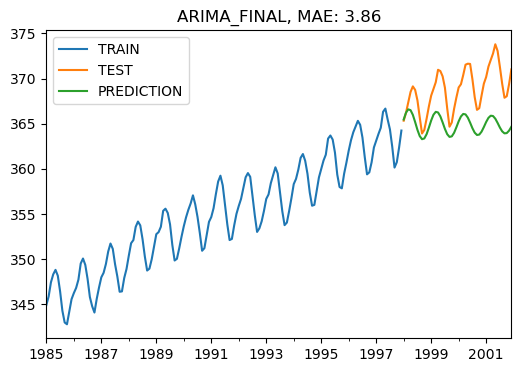

In [15]:
plot_co2(train, test, y_pred, "ARIMA_FINAL")

### SARIMA(p, d, q): Seasonal Autoregressive Integrated Moving Average

In [16]:
model = SARIMAX(train, order=(1, 0, 1), sesonal_order=(0, 0, 0, 12))
sarima_model = model.fit()

In [17]:
y_pred_test = sarima_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean

In [18]:
y_pred = pd.Series(y_pred, index=test.index)

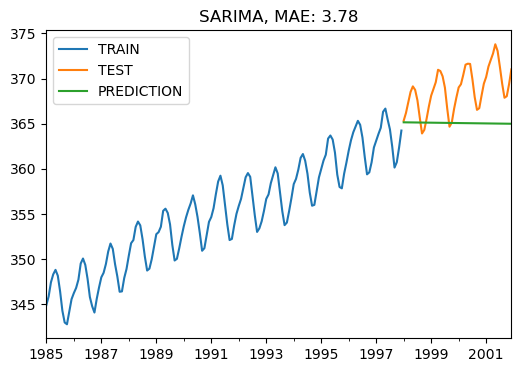

In [19]:
plot_co2(train, test, y_pred, "SARIMA")

##### Hyperparameter Optimization

In [20]:
p=d=q=range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [21]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarima_model= SARIMAX(train, order=param,
                                     seasonal_order=param_seasonal)
                results = sarima_model.fit()
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print(f'SARIMA{param}x{param_seasonal}12-AIC={aic}')
            except:
                continue
    print(f'SARIMA{best_order}x{best_seasonal_order}12-AIC={best_aic}')
        
    return best_order, best_seasonal_order  

In [22]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)


SARIMA(0, 0, 0)x(0, 0, 0, 12)12-AIC=6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12-AIC=6318.30521967864
SARIMA(0, 0, 0)x(0, 1, 0, 12)12-AIC=1643.9996657880383
SARIMA(0, 0, 0)x(0, 1, 1, 12)12-AIC=1428.2938925342032
SARIMA(0, 0, 0)x(1, 0, 0, 12)12-AIC=1949.37437192844
SARIMA(0, 0, 0)x(1, 0, 1, 12)12-AIC=1611.8639317176835
SARIMA(0, 0, 0)x(1, 1, 0, 12)12-AIC=1205.0254009707892
SARIMA(0, 0, 0)x(1, 1, 1, 12)12-AIC=973.2077279329183
SARIMA(0, 0, 1)x(0, 0, 0, 12)12-AIC=6269.190364756289
SARIMA(0, 0, 1)x(0, 0, 1, 12)12-AIC=5663.567928617296
SARIMA(0, 0, 1)x(0, 1, 0, 12)12-AIC=1229.8447515722833
SARIMA(0, 0, 1)x(0, 1, 1, 12)12-AIC=1126.5843176972912
SARIMA(0, 0, 1)x(1, 0, 0, 12)12-AIC=1467.5257828091267
SARIMA(0, 0, 1)x(1, 0, 1, 12)12-AIC=6260.917322339379
SARIMA(0, 0, 1)x(1, 1, 0, 12)12-AIC=1008.1602684830812
SARIMA(0, 0, 1)x(1, 1, 1, 12)12-AIC=767.6332847911981
SARIMA(0, 1, 0)x(0, 0, 0, 12)12-AIC=1523.9134546907358
SARIMA(0, 1, 0)x(0, 0, 1, 12)12-AIC=1154.7436199042209
SARIMA(0, 1, 0)x(0, 

In [23]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit()

In [24]:
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

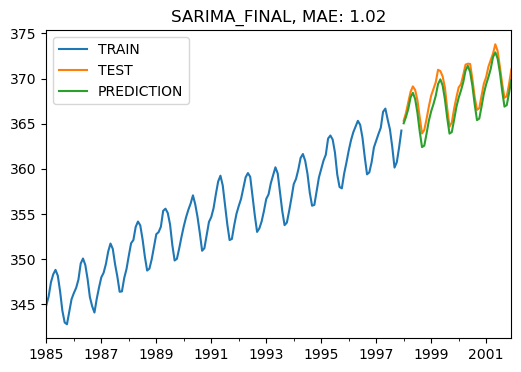

In [25]:
plot_co2(train, test, y_pred, "SARIMA_FINAL")

MAE'ye Göre SARIMA Optimizasyonu

In [26]:
p=d=q=range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [38]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarima_model= SARIMAX(train, order=param,
                                     seasonal_order=param_seasonal).fit()
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print(f'SARIMA{param}x{param_seasonal}12-MAE={mae}')
            except:
                continue
    print(f'BEST SARIMA{best_order}x{best_seasonal_order}12-MAE={best_mae}')
        
    return best_order, best_seasonal_order  

In [39]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12-MAE=368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12-MAE=324.17909156740365
SARIMA(0, 0, 0)x(0, 1, 0, 12)12-MAE=5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12-MAE=4.803324375598435
SARIMA(0, 0, 0)x(1, 0, 0, 12)12-MAE=5.19705098284179
SARIMA(0, 0, 0)x(1, 0, 1, 12)12-MAE=4.830229626242626
SARIMA(0, 0, 0)x(1, 1, 0, 12)12-MAE=3.323724885904871
SARIMA(0, 0, 0)x(1, 1, 1, 12)12-MAE=1.527958086202703
SARIMA(0, 0, 1)x(0, 0, 0, 12)12-MAE=364.9178691427657
SARIMA(0, 0, 1)x(0, 0, 1, 12)12-MAE=320.405059947706
SARIMA(0, 0, 1)x(0, 1, 0, 12)12-MAE=4.985339495359046
SARIMA(0, 0, 1)x(0, 1, 1, 12)12-MAE=4.765306207871163
SARIMA(0, 0, 1)x(1, 0, 0, 12)12-MAE=4.921186445913338
SARIMA(0, 0, 1)x(1, 0, 1, 12)12-MAE=355.132605118328
SARIMA(0, 0, 1)x(1, 1, 0, 12)12-MAE=3.674147902903819
SARIMA(0, 0, 1)x(1, 1, 1, 12)12-MAE=1.5667450356155566
SARIMA(0, 1, 0)x(0, 0, 0, 12)12-MAE=4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12-MAE=3.931540144591755
SARIMA(0, 1, 0)x(0, 1, 0, 12)12-MAE

In [40]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit()

In [41]:
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

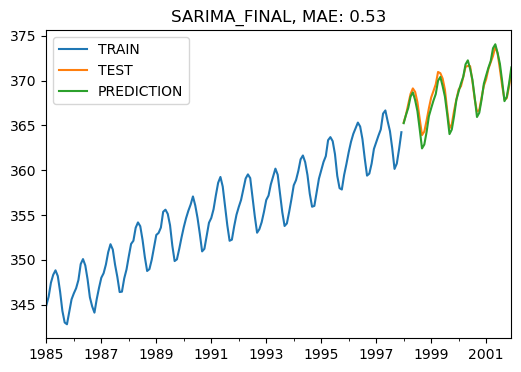

In [42]:
plot_co2(train, test, y_pred, "SARIMA_FINAL")

FINAL MODEL

In [47]:
model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit()

In [52]:
y_pred_test = sarima_final_model.get_forecast(steps=12)
y_pred = y_pred_test.predicted_mean
print(y_pred)

2002-01-01    371.930530
2002-02-01    372.718072
2002-03-01    373.585289
2002-04-01    374.494056
2002-05-01    375.101888
2002-06-01    374.687872
2002-07-01    372.962066
2002-08-01    371.034635
2002-09-01    369.551184
2002-10-01    369.728023
2002-11-01    371.087217
2002-12-01    372.581763
Freq: MS, Name: predicted_mean, dtype: float64
